In [94]:
library(tidyverse)     # For data manipulation & visualization
library(janitor)       # For cleaning column names
library(corrplot)      # For correlation plots
library(scales)        # For percentage scales in ggplot
library(brms)   # For Bayesian regression
library(bayesplot)  # For diagnostics & posterior checks

In [95]:
usvotes <- read_csv("USvotes.csv") %>% 
  clean_names()

Rows: 3107 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): STNAME, CTYNAME
dbl (7): TOT_POP, TOT_MALE, TOT_FEMALE, total_votes, per_gop, Crude.Prevalen...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [96]:
# Create binary variable for majority GOP
usvotes <- usvotes %>%
  mutate(
    majority_gop = if_else(per_gop > 50, 1, 0),
    scaled_depression = scale(crude_prevalence_estimate),
    scaled_race = scale(race),
    log_tot_pop = log(tot_pop),
    scaled_log_pop = as.numeric(scale(log_tot_pop)),
    state = as.factor(stname)
  ) %>% 
  drop_na(per_gop, crude_prevalence_estimate, race)


# EDA

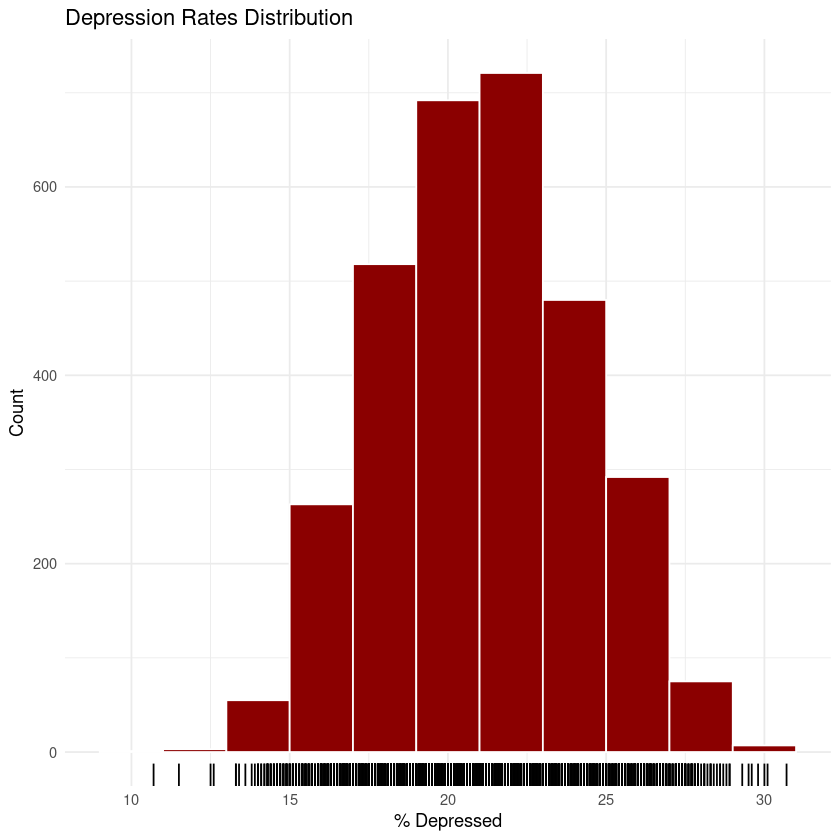

In [97]:
# Histogram of depression rates with rug plot to check outliers
ggplot(usvotes, aes(x = crude_prevalence_estimate)) +
  geom_histogram(binwidth = 2, fill = "darkred", color = "white") +
  geom_rug() +
  labs(title = "Depression Rates Distribution", x = "% Depressed", y = "Count") +
  theme_minimal()



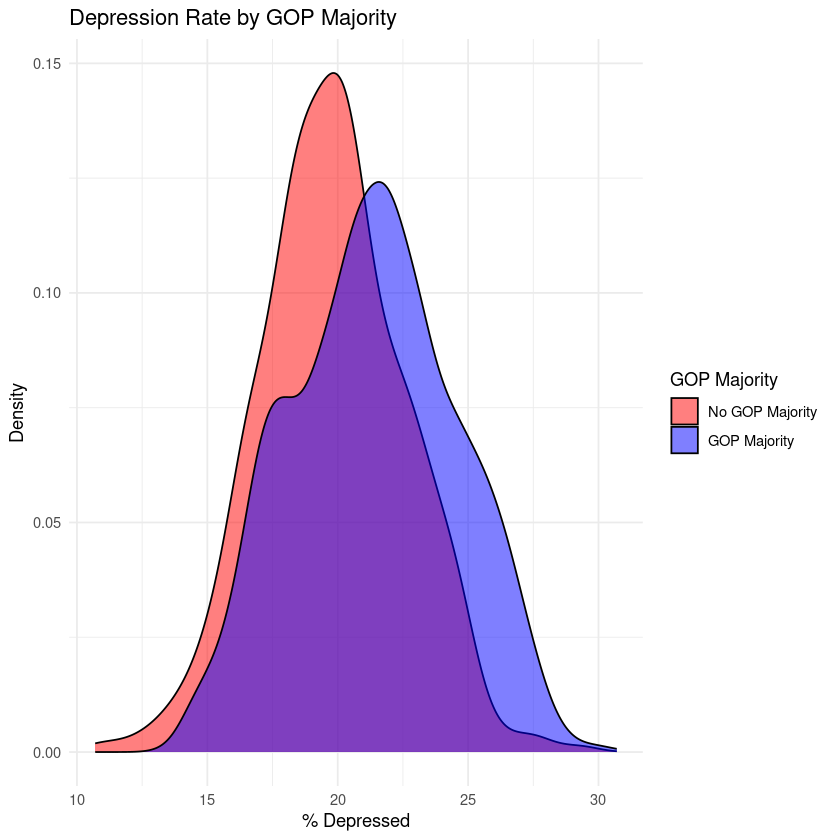

In [98]:
# Density plot: Depression rates by GOP majority
ggplot(usvotes, aes(x = crude_prevalence_estimate, fill = factor(majority_gop))) +
  geom_density(alpha = 0.5) +
  scale_fill_manual(values = c("0" = "red", "1" = "blue"),
                    labels = c("No GOP Majority", "GOP Majority")) +
  labs(title = "Depression Rate by GOP Majority", x = "% Depressed", y = "Density", fill = "GOP Majority") +
  theme_minimal()



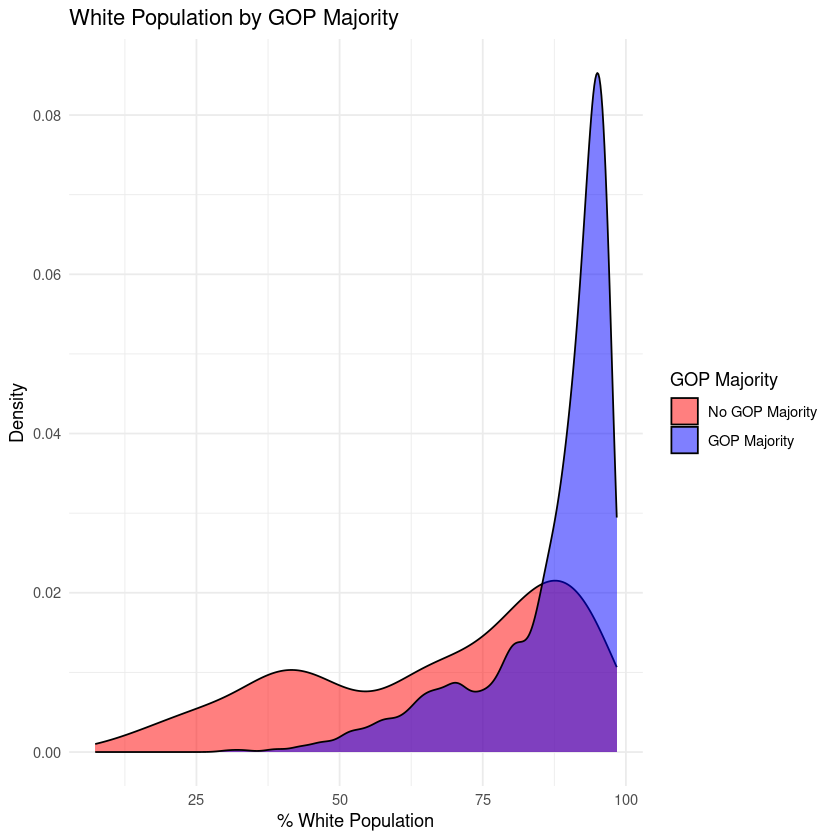

In [99]:
# Density plot: Race by GOP majority
ggplot(usvotes, aes(x = race, fill = factor(majority_gop))) +
  geom_density(alpha = 0.5) +
  scale_fill_manual(values = c("0" = "red", "1" = "blue"),
                    labels = c("No GOP Majority", "GOP Majority")) +
  labs(title = "White Population by GOP Majority", x = "% White Population", y = "Density", fill = "GOP Majority") +
  theme_minimal()



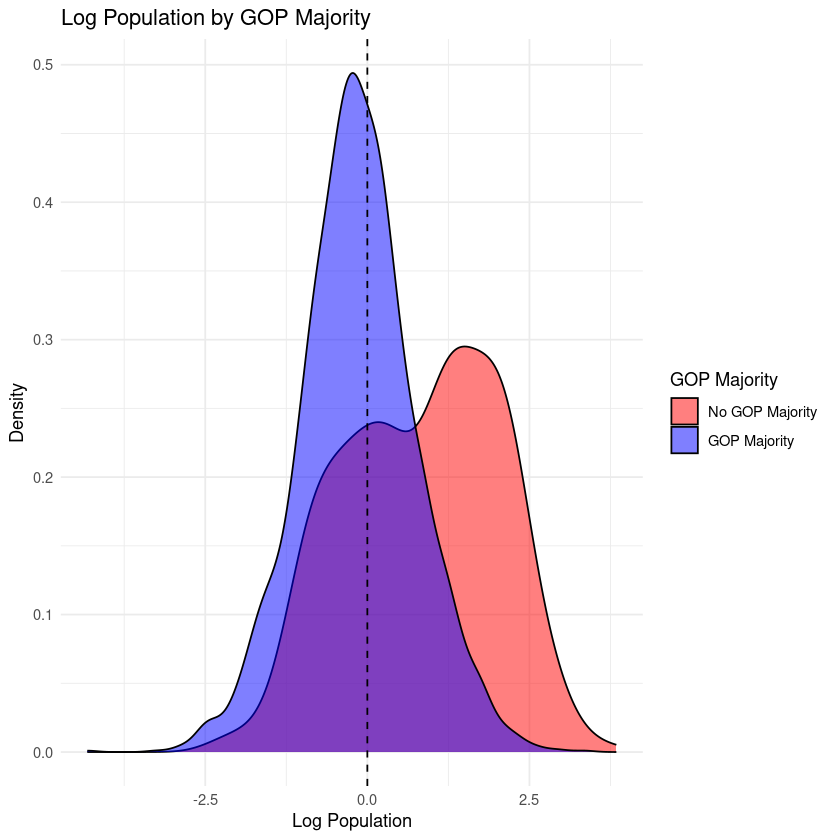

In [100]:
# Density plot: Log population by GOP majority (using log(tot_pop))
ggplot(usvotes, aes(x = scaled_log_pop, fill = factor(majority_gop))) +
  geom_density(alpha = 0.5) +
  geom_vline(xintercept = 0, linetype = "dashed") +
  scale_fill_manual(values = c("0" = "red", "1" = "blue"),
                    labels = c("No GOP Majority", "GOP Majority")) +
  labs(title = "Log Population by GOP Majority", x = "Log Population", y = "Density", fill = "GOP Majority") +
  theme_minimal()



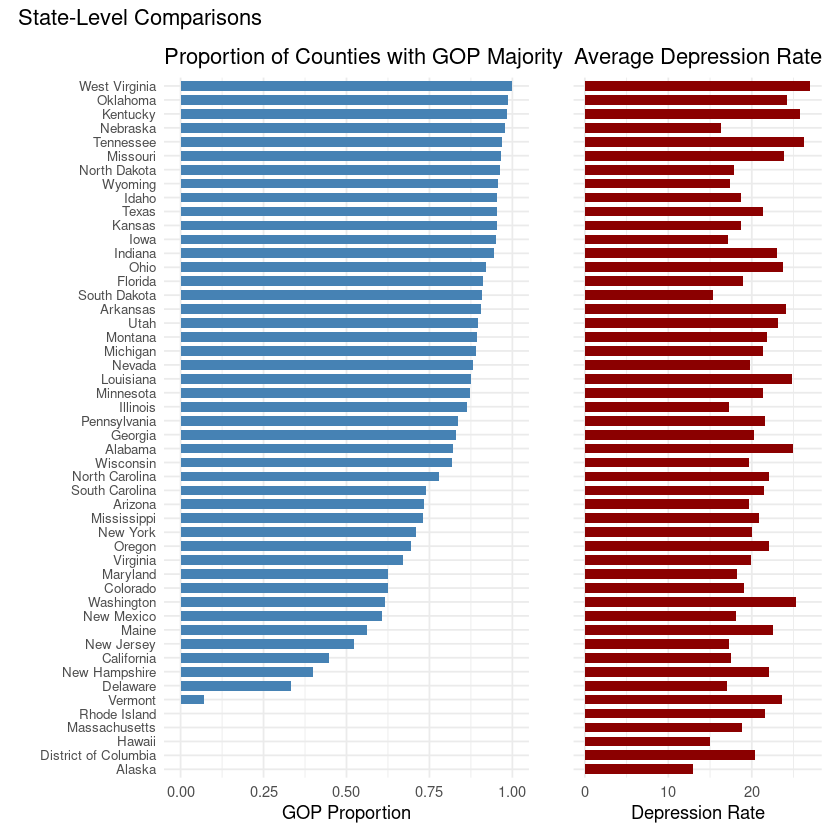

In [137]:
library(tidyverse)
library(patchwork)  # For combining plots

# Calculate state summaries
state_summary <- usvotes %>%
  group_by(state) %>%
  summarise(
    gop_majority = mean(majority_gop),
    depression = mean(crude_prevalence_estimate)
  ) %>%
  arrange(gop_majority)

# Create GOP majority plot
p1 <- ggplot(state_summary, aes(x = reorder(state, gop_majority), y = gop_majority)) +
  geom_bar(stat = "identity", fill = "steelblue", width = 0.7) +
  labs(title = "Proportion of Counties with GOP Majority",
       x = "", y = "GOP Proportion") +
  coord_flip() +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 8))

# Create depression plot
p2 <- ggplot(state_summary, aes(x = reorder(state, gop_majority), y = depression)) +
  geom_bar(stat = "identity", fill = "darkred", width = 0.7) +
  labs(title = "Average Depression Rate",
       x = "", y = "Depression Rate") +
  coord_flip() +
  theme_minimal() +
  theme(axis.text.y = element_blank())  # Remove duplicate state labels

# Combine plots side by side
p1 + p2 + 
  plot_layout(ncol = 2, widths = c(2.5, 1.7)) + 
  plot_annotation(title = "State-Level Comparisons")

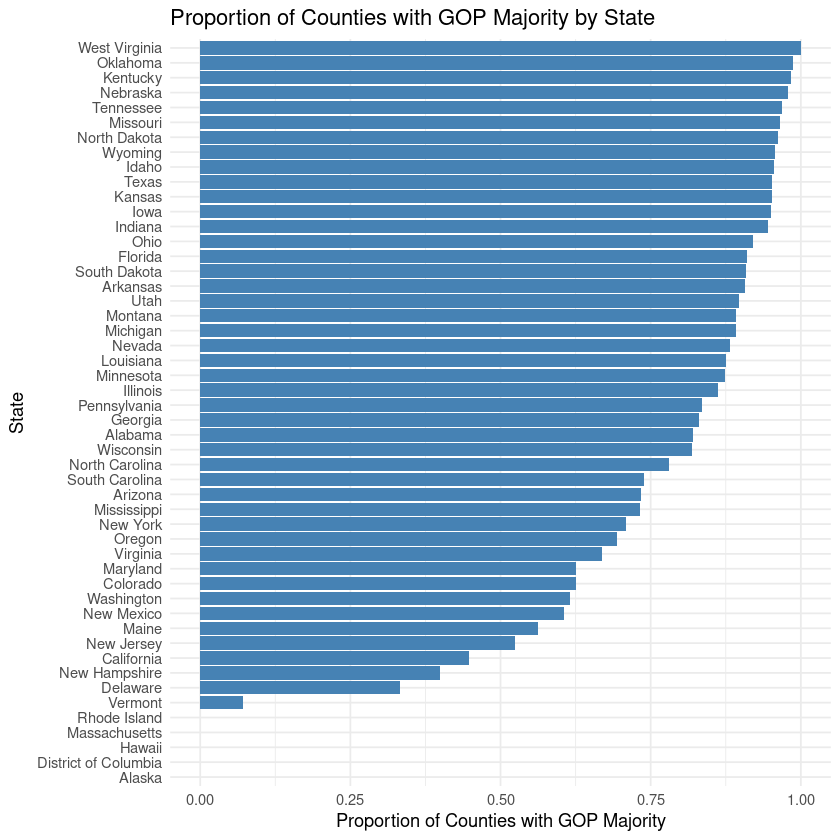

In [122]:
# Proportion of GOP majority by state
state_summary <- usvotes %>%
  group_by(state) %>%
  summarise(
    prop_gop_majority = mean(majority_gop),
    avg_depression = mean(crude_prevalence_estimate)  # Average depression rate
  ) %>%
  arrange(prop_gop_majority)  # Order by GOP majority proportion
ggplot(state_summary, aes(x = reorder(state, prop_gop_majority), y = prop_gop_majority)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(title = "Proportion of Counties with GOP Majority by State",
       x = "State", y = "Proportion of Counties with GOP Majority") +
  theme_minimal()



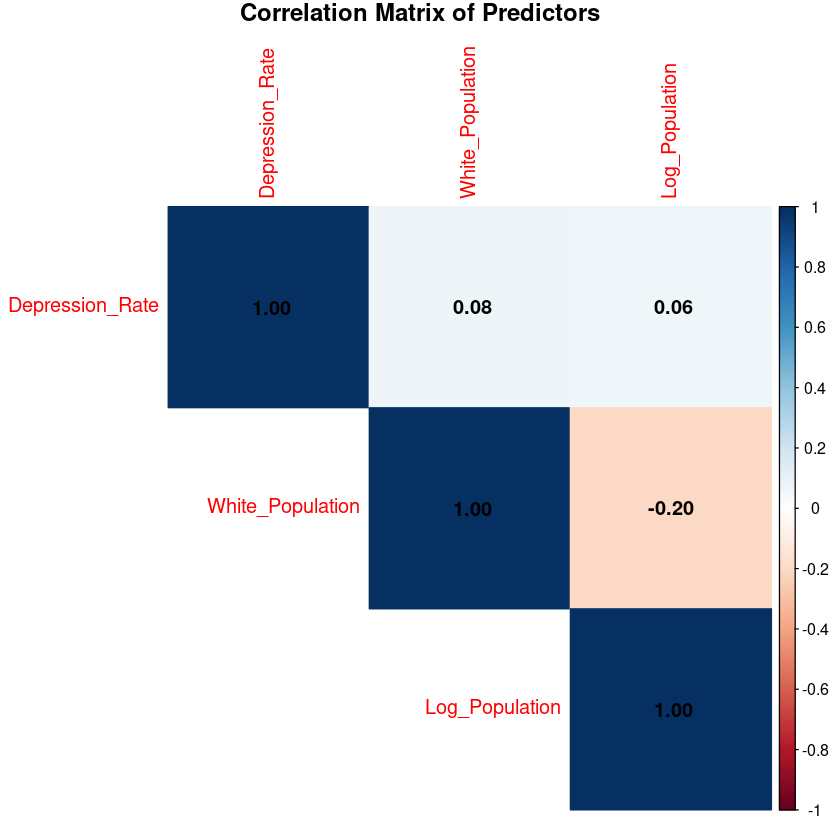

In [102]:
# Correlation matrix with renamed columns (using log(tot_pop))
cor_vars <- usvotes %>% 
  select(
    Depression_Rate = crude_prevalence_estimate,
    White_Population = race,
    Log_Population = scaled_log_pop  # Select tot_pop, then transform below
  ) %>%
  cor()
corrplot(cor_vars, 
         method = "color", 
         type = "upper", 
         addCoef.col = "black",
         title = "Correlation Matrix of Predictors",
         mar = c(0, 0, 1, 0))

# Modeling

### Full model

In [103]:
prior <- c(
  set_prior("normal(0, 2)", class = "b"),
  set_prior("student_t(3, 0, 2.5)", class = "Intercept"),
  set_prior("normal(0,1)", class = "sd") 
)

In [104]:
# hier_model <- brm(
#   majority_gop ~ scaled_depression + scaled_race + scaled_log_pop + (1 | state),
#   data = usvotes,
#   family = bernoulli(),
#   prior = prior,
#   chains = 4,
#   iter = 4000,
#   save_pars = save_pars(all = TRUE),
#   cores = 10,
#   seed = 42
# )
# saveRDS(hier_model, "models/hier_model.rds")

hier_model <- readRDS("models/hier_model.rds")

### State depression model

In [105]:
# state_depression_model <- brm(
#   majority_gop ~ scaled_depression + scaled_race + scaled_log_pop + (1 + scaled_depression | state),
#   data = usvotes,
#   family = bernoulli(),
#   prior = prior,
#   chains = 4,
#   iter = 4000,
#   save_pars = save_pars(all = TRUE),
#   cores = 10,
#   seed = 42
# )
# saveRDS(state_depression_model, "models/state_depression_model.rds")

state_depression_model <- readRDS("models/state_depression_model.rds")

### State-only model

In [106]:
# state_only_prior <- c(
#   set_prior("student_t(3, 0, 2.5)", class = "Intercept"),
#   set_prior("normal(0,1)", class = "sd") 
# )

# state_only_model <- brm(
#   majority_gop ~ 1 + (1 | state),
#   data = usvotes,
#   family = bernoulli(),
#   prior = state_only_prior,
#   chains = 4,
#   iter = 4000,
#   save_pars = save_pars(all = TRUE),
#   cores = 10,
#   seed = 42
# )
# saveRDS(state_only_model, "models/state_only_model.rds")

state_only_model <- readRDS("models/state_only_model.rds")


### Exclude depression

In [107]:
# no_depression_model <- brm(
#   majority_gop ~ scaled_race + scaled_log_pop + (1 | state),
#   data = usvotes,
#   family = bernoulli(),
#   prior = prior,
#   chains = 4,
#   iter = 4000,
#   save_pars = save_pars(all = TRUE),
#   cores = 10,
#   seed = 42
# )
# saveRDS(no_depression_model, "models/no_depression_model.rds")

no_depression_model <- readRDS("models/no_depression_model.rds")


In [108]:
loo_state  <- loo(state_only_model, moment_match = TRUE)
loo_full  <- loo(hier_model, moment_match = TRUE)
loo_reduced <- loo(no_depression_model, moment_match = TRUE)
loo_state_depression <- loo(state_depression_model, moment_match = TRUE)

In [109]:
comp <- loo_compare(loo_full, loo_reduced, loo_state, loo_state_depression)
print(comp)

# elpd_diff se_diff
# state_depression_model    0.0       0.0 
# hier_model              -14.2       7.0 
# no_depression_model     -29.0       9.0 
# state_only_model       -451.3      29.8

                       elpd_diff se_diff
state_depression_model    0.0       0.0 
hier_model              -14.2       7.0 
no_depression_model     -29.0       9.0 
state_only_model       -451.3      29.8 


### selected model

In [110]:
model <- state_depression_model          

print(loo(model))                        


Computed from 8000 by 3107 log-likelihood matrix.

         Estimate   SE
elpd_loo   -665.3 31.0
p_loo        66.9  4.9
looic      1330.7 62.0
------
MCSE of elpd_loo is 0.1.
MCSE and ESS estimates assume MCMC draws (r_eff in [0.7, 2.1]).

All Pareto k estimates are good (k < 0.7).
See help('pareto-k-diagnostic') for details.


In [143]:
sd(usvotes$crude_prevalence_estimate)
sd(usvotes$log_tot_pop)
sd(usvotes$race)

[1] 3.136818

[1] 1.510026

[1] 15.87568

In [111]:
summary(model)

 Family: bernoulli 
  Links: mu = logit 
Formula: majority_gop ~ scaled_depression + scaled_race + scaled_log_pop + (1 + scaled_depression | state) 
   Data: usvotes (Number of observations: 3107) 
  Draws: 4 chains, each with iter = 4000; warmup = 2000; thin = 1;
         total post-warmup draws = 8000

Multilevel Hyperparameters:
~state (Number of levels: 50) 
                                 Estimate Est.Error l-95% CI u-95% CI Rhat
sd(Intercept)                        2.03      0.27     1.55     2.61 1.00
sd(scaled_depression)                1.45      0.27     0.96     2.02 1.00
cor(Intercept,scaled_depression)     0.44      0.18     0.04     0.74 1.00
                                 Bulk_ESS Tail_ESS
sd(Intercept)                        3782     5199
sd(scaled_depression)                3729     5232
cor(Intercept,scaled_depression)     3689     5144

Regression Coefficients:
                  Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept             2.62 

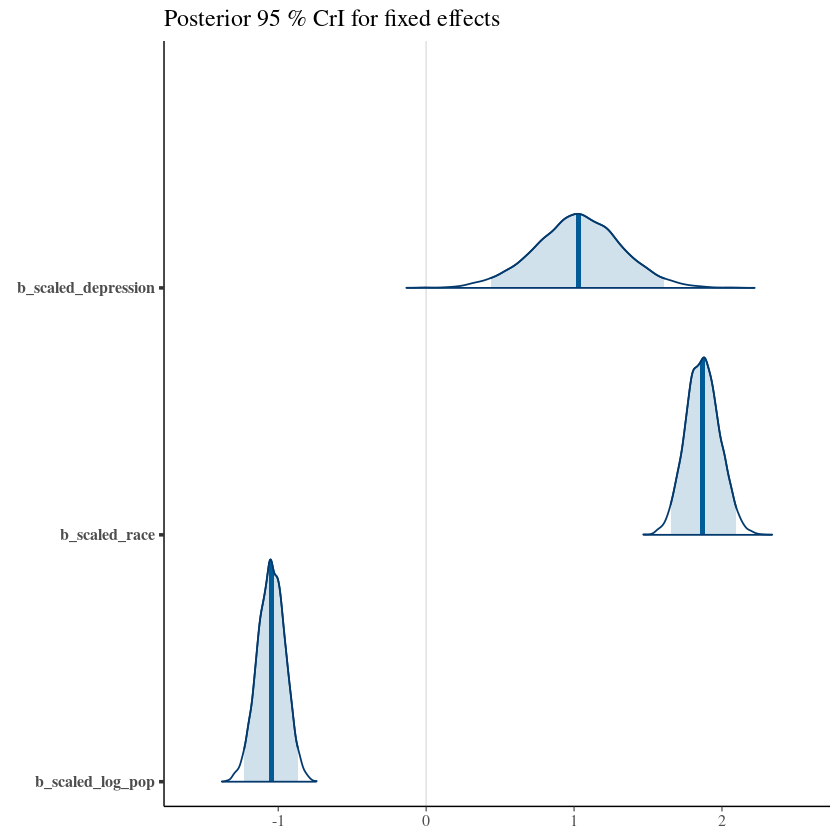

In [112]:
mcmc_areas(
  as_draws_df(model, variable = c("b_scaled_depression",
                                  "b_scaled_race",
                                  "b_scaled_log_pop")),
  prob = 0.95) +
  ggtitle("Posterior 95 % CrI for fixed effects")

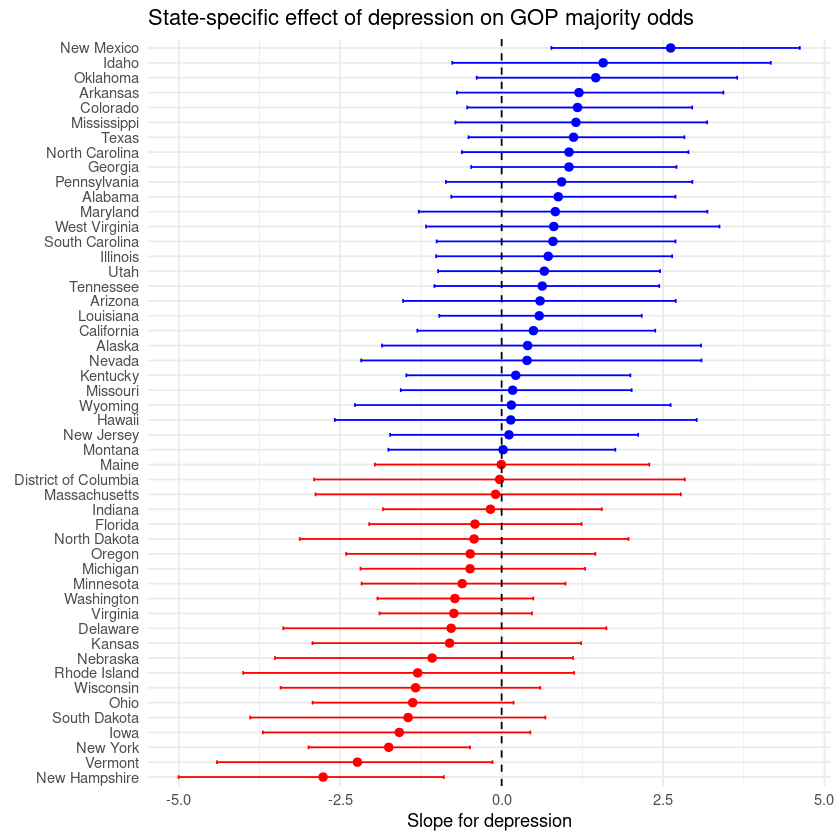

In [145]:
slope_mat   <- ranef(model)$state[, , "scaled_depression"]
slope_df    <- as_tibble(slope_mat, rownames = "State")

ggplot(slope_df,
       aes(x = reorder(State, Estimate),
           y = Estimate,
           colour = Estimate > 0)) +           # blue = positive, red = negative
  geom_point(size = 2) +
  geom_errorbar(aes(ymin = Q2.5, ymax = Q97.5), width = .25) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  coord_flip() +
  scale_colour_manual(values = c("red", "blue"), guide = "none") +
  labs(title = "State-specific effect of depression on GOP majority odds",
       y = "Slope for depression", x = NULL) +
  theme_minimal(base_size = 11)


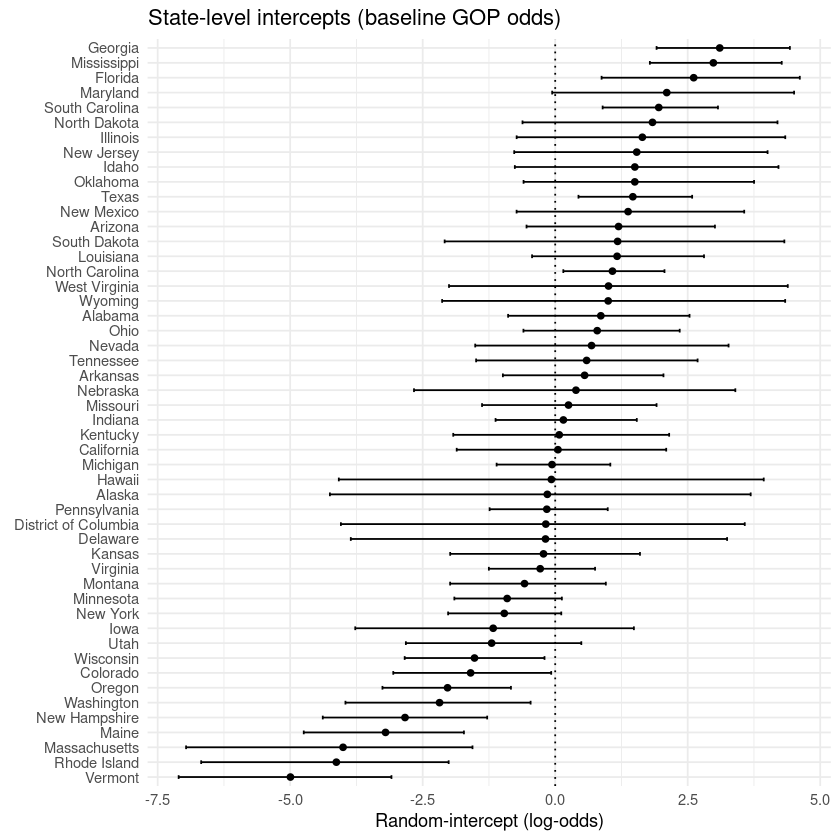

In [114]:
int_mat <- ranef(model)$state[, , "Intercept"]
int_df  <- as_tibble(int_mat, rownames = "State")

ggplot(int_df,
       aes(x = reorder(State, Estimate), y = Estimate)) +
  geom_point() +
  geom_errorbar(aes(ymin = Q2.5, ymax = Q97.5), width = .25) +
  coord_flip() +
  geom_hline(yintercept = 0, linetype = "dotted") +
  labs(title = "State-level intercepts (baseline GOP odds)",
       y = "Random-intercept (log-odds)", x = NULL) +
  theme_minimal(base_size = 11)

# PP check

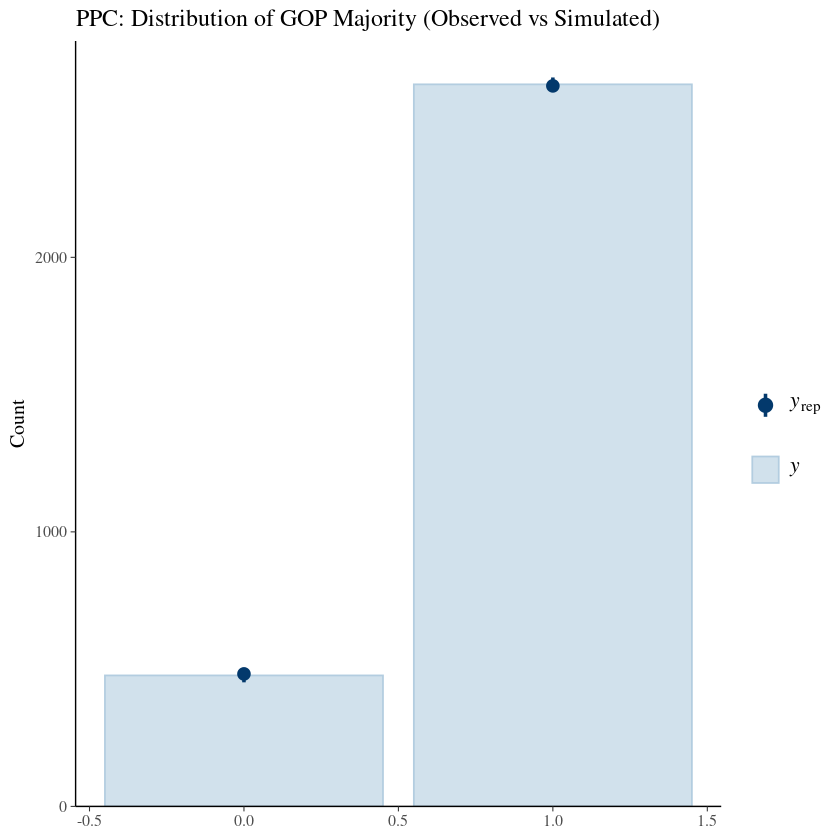

In [115]:
pp_check(model, type = "bars", ndraws = 100) +
  labs(title = "PPC: Distribution of GOP Majority (Observed vs Simulated)")

Using all posterior draws for ppc type 'stat' by default.

Note: in most cases the default test statistic 'mean' is too weak to detect anything of interest.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


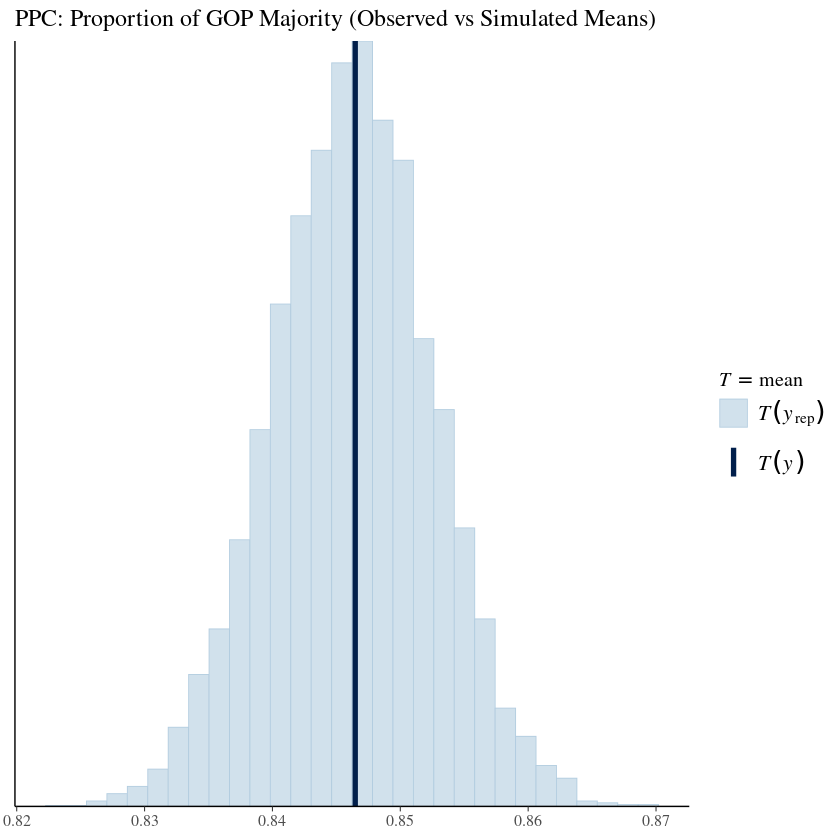

In [116]:
pp_check(model, type = "stat", stat = "mean") +
  labs(title = "PPC: Proportion of GOP Majority (Observed vs Simulated Means)")


In [ ]:
state_pred <- usvotes %>%
  mutate(predicted = fitted(model)[, "Estimate"]) %>%
  group_by(state) %>%
  summarise(
    observed_mean = mean(majority_gop),
    predicted_mean = mean(predicted)
  )

In [155]:
rmse <- sqrt(mean((state_pred$observed_mean - state_pred$predicted_mean)^2))
rmse

[1] 0.03749589

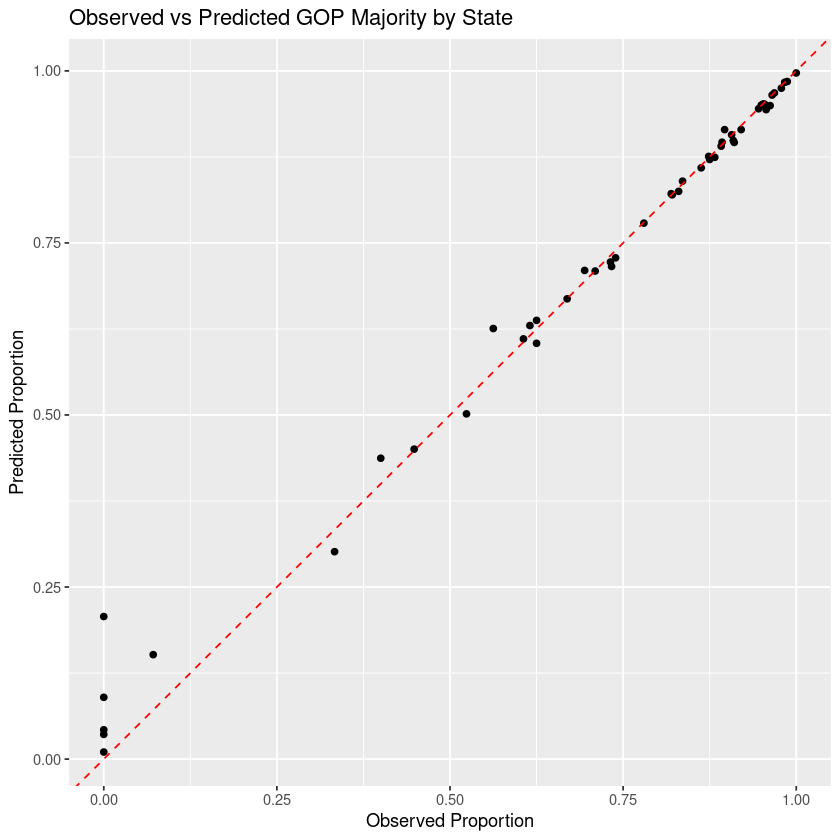

In [ ]:
ggplot(state_pred, aes(x = observed_mean, y = predicted_mean)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Observed vs Predicted GOP Majority by State",
       x = "Observed Proportion",
       y = "Predicted Proportion")


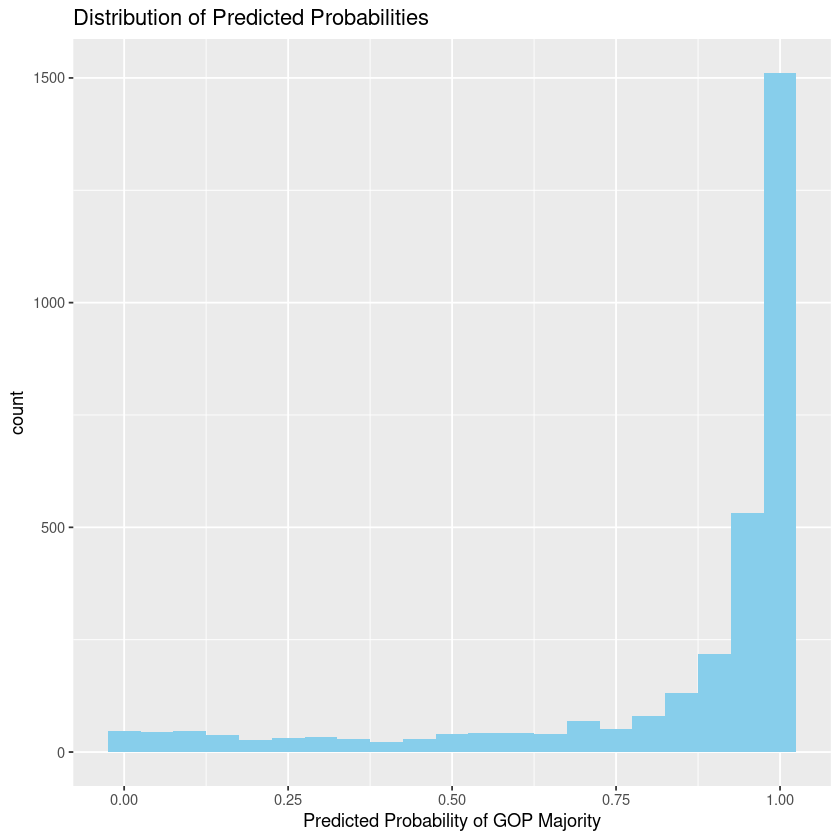

In [118]:
pred_probs <- fitted(model)[, "Estimate"]

ggplot(data.frame(pred = pred_probs), aes(x = pred)) +
  geom_histogram(binwidth = 0.05, fill = "skyblue") +
  labs(title = "Distribution of Predicted Probabilities", x = "Predicted Probability of GOP Majority")


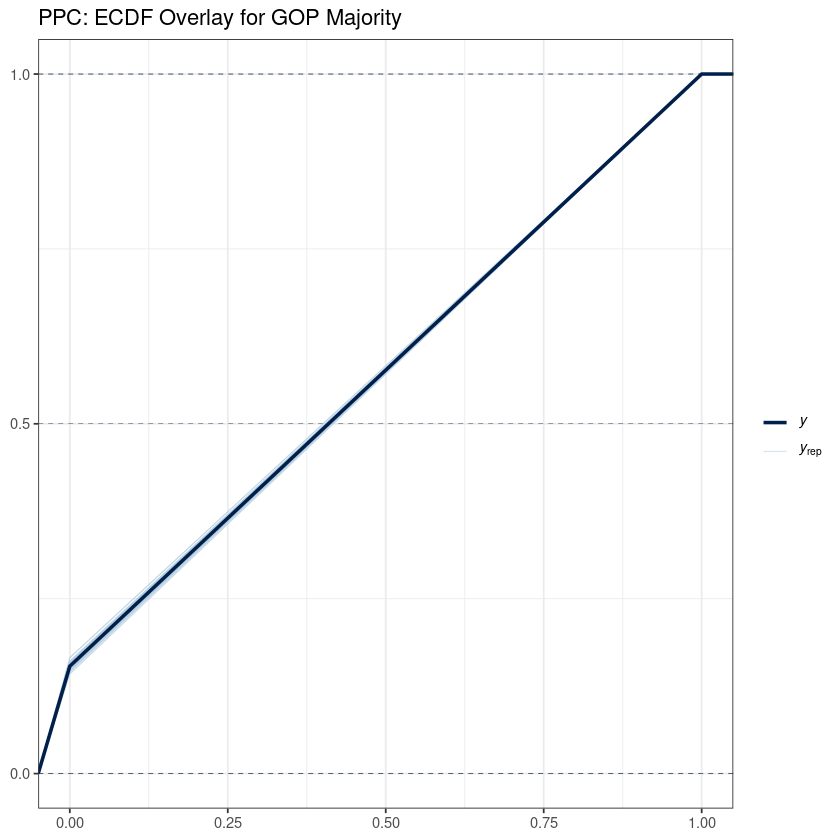

In [119]:
pp_check(model, type = "ecdf_overlay", ndraws = 50) +
  labs(title = "PPC: ECDF Overlay for GOP Majority") +
  theme_bw()


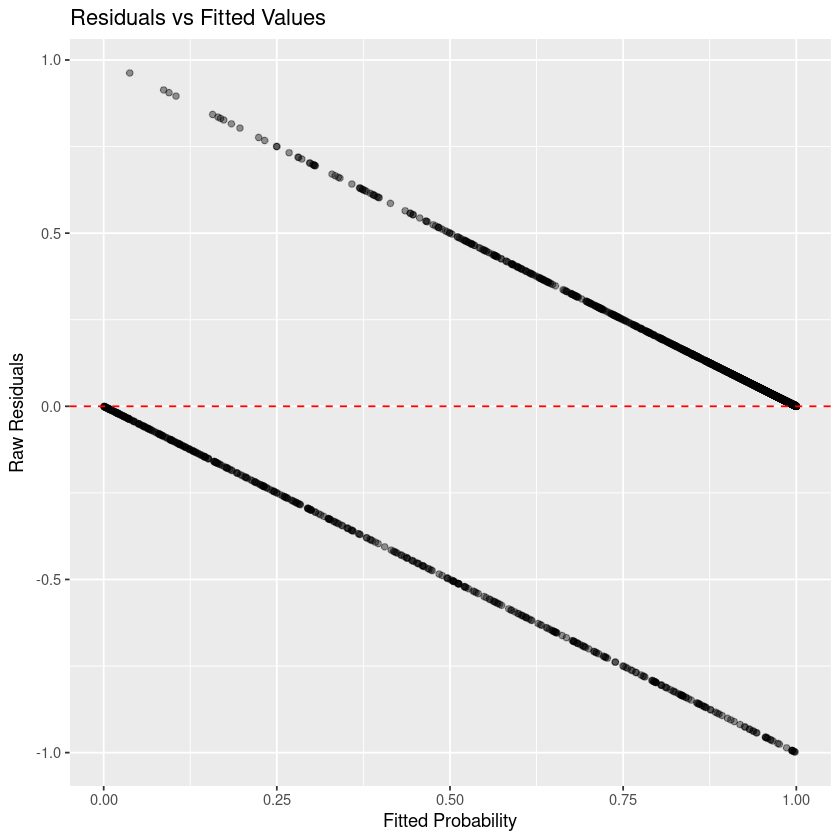

In [120]:
fitted_probs <- fitted(model)[, "Estimate"]
residuals_raw <- usvotes$majority_gop - fitted_probs

ggplot(data.frame(fitted = fitted_probs, residual = residuals_raw), aes(x = fitted, y = residual)) +
  geom_point(alpha = 0.4) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Residuals vs Fitted Values",
       x = "Fitted Probability",
       y = "Raw Residuals")


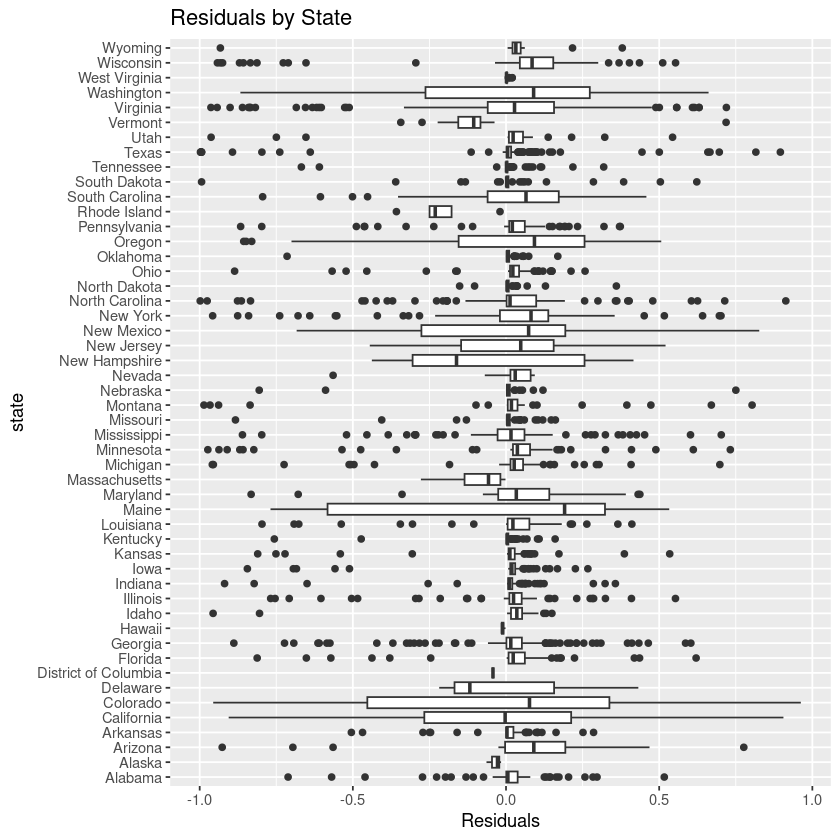

In [147]:
ggplot(data.frame(state = usvotes$state, residual = residuals_raw), aes(x = state, y = residual)) +
  geom_boxplot() +
  coord_flip() +
  labs(title = "Residuals by State",
       y = "Residuals")
